# Blocks example: training an MLP on MNIST

This notebooks is based on the [introduction tutorial](http://blocks.readthedocs.org/en/latest/tutorial.html) in the Blocks documentation.

In [41]:
import numpy as np
from matplotlib import cm, pyplot as plt
%matplotlib inline

In [42]:
import blocks

In [43]:
from theano import tensor
x = tensor.matrix('features')

### Building the model

#### Long way

In [44]:
from blocks.bricks import Linear, Rectifier, Softmax
input_to_hidden = Linear(name='input_to_hidden', input_dim=784, output_dim=100)
h = Rectifier().apply(input_to_hidden.apply(x))
hidden_to_output = Linear(name='hidden_to_output', input_dim=100, output_dim=10)
y_hat = Softmax().apply(hidden_to_output.apply(h))

In [45]:
y = tensor.lmatrix('targets')
from blocks.bricks.cost import CategoricalCrossEntropy
cost = CategoricalCrossEntropy().apply(y.flatten(), y_hat)

#### Short way

In [46]:
from blocks.bricks import WEIGHT
from blocks.graph import ComputationGraph
from blocks.filter import VariableFilter
cg = ComputationGraph(cost)
W1, W2 = VariableFilter(roles=[WEIGHT])(cg.variables)
cost = cost + 0.005 * (W1 ** 2).sum() + 0.005 * (W2 ** 2).sum()
cost.name = 'cost_with_regularization'

In [47]:
from blocks.bricks import MLP
mlp = MLP(activations=[Rectifier(), Softmax()], dims=[784, 100, 10]).apply(x)

### Initialize the model

In [48]:
from blocks.initialization import IsotropicGaussian, Constant
input_to_hidden.weights_init = hidden_to_output.weights_init = IsotropicGaussian(0.01)
input_to_hidden.biases_init = hidden_to_output.biases_init = Constant(0)
input_to_hidden.initialize()
hidden_to_output.initialize()

In [49]:
before_training = W1.get_value() 
before_training

array([[-0.01124021,  0.01247464, -0.00062076, ...,  0.00480713,
        -0.00179161,  0.00757473],
       [ 0.01639301, -0.00317771,  0.00785715, ...,  0.00195937,
         0.00166439,  0.00264705],
       [-0.00766038, -0.01124101, -0.00345078, ...,  0.0033863 ,
        -0.01123138,  0.04039003],
       ..., 
       [ 0.00923156, -0.00390816, -0.01283273, ..., -0.01571902,
        -0.00616801,  0.00398714],
       [ 0.01128367,  0.00231132, -0.01634018, ...,  0.01330872,
        -0.00422074, -0.00572795],
       [-0.00667289,  0.00749016,  0.00049473, ...,  0.00313379,
        -0.00105796,  0.00246553]])

### Visualize before training

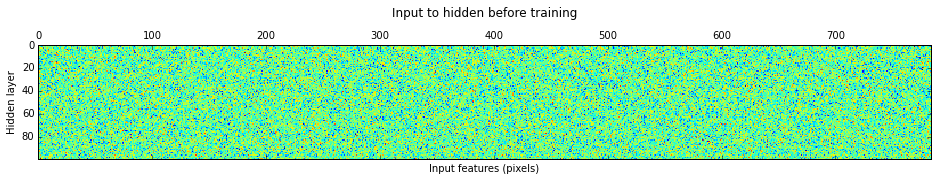

In [50]:
plt.matshow(before_training.transpose());
plt.title('Input to hidden before training', y=1.2);
plt.xlabel('Input features (pixels)');
plt.ylabel('Hidden layer');

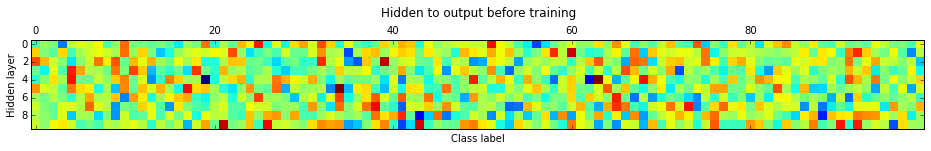

In [51]:
plt.matshow(W2.get_value().transpose(), interpolation='nearest');
plt.title('Hidden to output before training', y=1.2);
plt.xlabel('Class label');
plt.ylabel('Hidden layer');

### Load the MNIST digit dataset

In [52]:
from fuel.datasets import MNIST
mnist = MNIST("train")

In [53]:
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme
from fuel.transformers import Flatten
data_stream = Flatten(DataStream.default_stream(
        mnist,
        iteration_scheme=SequentialScheme(mnist.num_examples, batch_size=256)))

### Training

In [54]:
from blocks.algorithms import GradientDescent, Scale
algorithm = GradientDescent(cost=cost, params=cg.parameters, step_rule=Scale(learning_rate=0.1))

In [55]:
mnist_test = MNIST("test")
data_stream_test = Flatten(DataStream.default_stream(
        mnist_test, 
        iteration_scheme=SequentialScheme(mnist_test.num_examples, batch_size=1024)))

In [56]:
from blocks.extensions.monitoring import DataStreamMonitoring
monitor = DataStreamMonitoring(variables=[cost], data_stream=data_stream_test, prefix="test")

In [57]:
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing
main_loop = MainLoop(data_stream=data_stream, 
                     algorithm=algorithm, 
                     extensions=[monitor, FinishAfter(after_n_epochs=10), Printing()])
main_loop.run() 


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 training_started: True
Log records from the iteration 0:
	 test_cost_with_regularization: 2.34159467379


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 235
	 received_first_batch: True
	 training_started: True
Log records from the iteration 235:
	 test_cost_with_regularization: 0.658715868907


---------------------------------------------------------------------

### Visualize after training

In [58]:
np.shape(W1.get_value())

(784, 100)

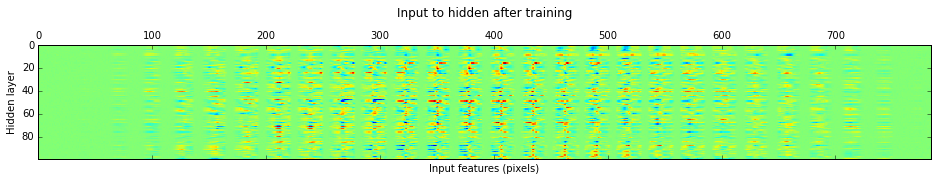

In [59]:
plt.matshow(W1.get_value().transpose());
plt.title('Input to hidden after training', y=1.2);
plt.xlabel('Input features (pixels)');
plt.ylabel('Hidden layer');

In [60]:
np.shape(W2.get_value())

(100, 10)

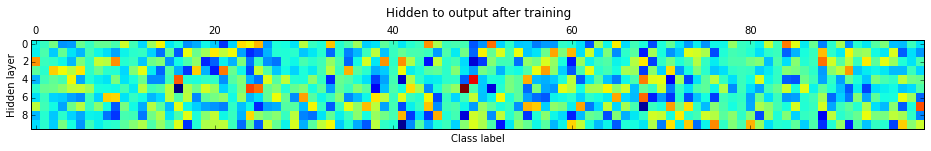

In [61]:
plt.matshow(W2.get_value().transpose(), interpolation='nearest');
plt.title('Hidden to output after training', y=1.2);
plt.xlabel('Class label');
plt.ylabel('Hidden layer');

In [62]:
cg.auxiliary_variables

[W_norm, b_norm, W_norm, b_norm]

In [63]:
cg.parameters

[b, b, W, W]

In [64]:
len(cg.parameters[0].get_value())

10

In [65]:
cg.parameters[0].get_value()

array([-0.27421801,  0.43420331, -0.06618187, -0.16805644,  0.11922533,
        0.51873744, -0.00166414,  0.24187953, -0.70220178, -0.10172336])

In [66]:
len(cg.parameters[1].get_value())

100

In [67]:
cg.inputs

[targets, features]

In [68]:
cg.outputs

[categoricalcrossentropy_apply_cost]

### Visualize digits

In [69]:
datapoints = mnist.get_data(request=[0,1,2])

In [76]:
datapoints

(array([[[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]],
 
 
        [[[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ..., 
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8), array([[5],
        [0],
        [4]], dtype=uint8))

In [77]:
digit1 = datapoints[0][0][0]

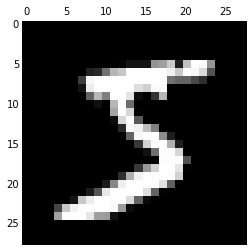

In [71]:
plt.matshow(digit1, interpolation='nearest', cmap = cm.Greys_r);

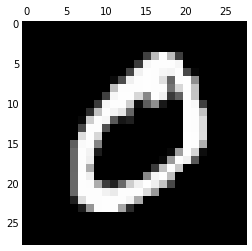

In [72]:
digit2 = datapoints[0][1][0]
plt.matshow(digit2, interpolation='nearest', cmap = cm.Greys_r);

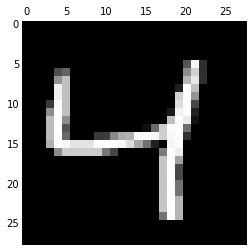

In [73]:
digit3 = datapoints[0][2][0]
plt.matshow(digit3, interpolation='nearest', cmap = cm.Greys_r);